In [1]:
# prerequisites
import torch
import itertools
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [2]:
import random

random.seed(10)

In [2]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=100)
if torch.cuda.is_available():
    vae.cuda()

In [3]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=100, bias=True)
  (fc32): Linear(in_features=256, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [7]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [4]:
fixed_z_ = torch.randn((5 * 5, 100)).cuda()
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    trainloss.append(train_loss/len(train_loader.dataset))
    
    test_images=vae.decoder(fixed_z_)
    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
       ax[i, j].get_xaxis().set_visible(False)
       ax[i, j].get_yaxis().set_visible(False)

    for k in range(5*5):
       i = k // 5
       j = k % 5
       ax[i, j].cla()
       ax[i, j].imshow(test_images[k, :].cpu().data.view(28, 28).numpy(), cmap='gray')

    label = 'Synthesis'
    fig.text(0.5, 0.04, label, ha='center')
    plt.show()
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [5]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
    testloss.append(test_loss/len(test_loader.dataset))    
    test_loss /= len(test_loader.dataset)
    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(5*5):
        i = k // 5
        j = k % 5
        ax[i, j].cla()
        ax[i, j].imshow(recon[k, :].cpu().data.view(28, 28).numpy(), cmap='gray')
    plt.show()
    print('====> Test set loss: {:.4f}'.format(test_loss))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 543.905313
Train Epoch: 1 [10000/60000 (17%)]	Loss: 192.600234
Train Epoch: 1 [20000/60000 (33%)]	Loss: 184.706152
Train Epoch: 1 [30000/60000 (50%)]	Loss: 170.752129
Train Epoch: 1 [40000/60000 (67%)]	Loss: 159.496768
Train Epoch: 1 [50000/60000 (83%)]	Loss: 150.465527


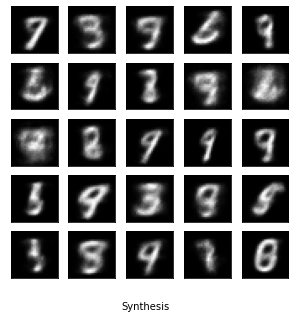

====> Epoch: 1 Average loss: 176.8322


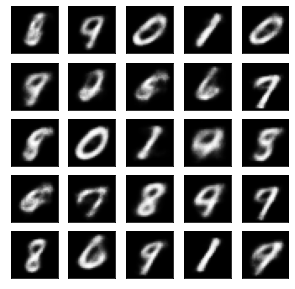

====> Test set loss: 142.6491
Train Epoch: 2 [0/60000 (0%)]	Loss: 139.711387
Train Epoch: 2 [10000/60000 (17%)]	Loss: 136.924053
Train Epoch: 2 [20000/60000 (33%)]	Loss: 133.125137
Train Epoch: 2 [30000/60000 (50%)]	Loss: 131.252305
Train Epoch: 2 [40000/60000 (67%)]	Loss: 130.603457
Train Epoch: 2 [50000/60000 (83%)]	Loss: 128.294609


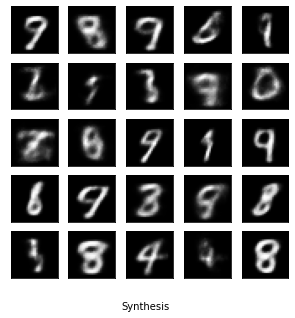

====> Epoch: 2 Average loss: 131.2773


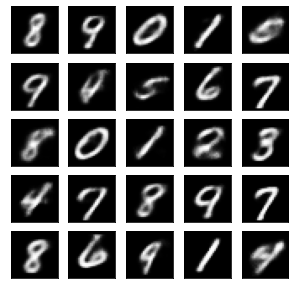

====> Test set loss: 122.5053
Train Epoch: 3 [0/60000 (0%)]	Loss: 128.186523
Train Epoch: 3 [10000/60000 (17%)]	Loss: 122.712178
Train Epoch: 3 [20000/60000 (33%)]	Loss: 119.984756
Train Epoch: 3 [30000/60000 (50%)]	Loss: 117.943223
Train Epoch: 3 [40000/60000 (67%)]	Loss: 114.247383
Train Epoch: 3 [50000/60000 (83%)]	Loss: 116.654082


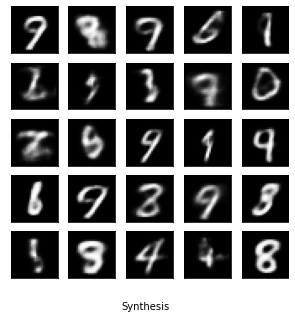

====> Epoch: 3 Average loss: 119.4356


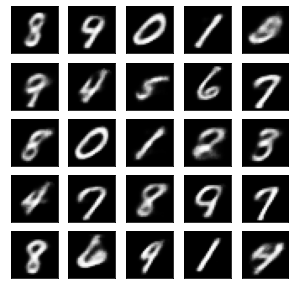

====> Test set loss: 115.2941
Train Epoch: 4 [0/60000 (0%)]	Loss: 115.463701
Train Epoch: 4 [10000/60000 (17%)]	Loss: 115.601465
Train Epoch: 4 [20000/60000 (33%)]	Loss: 111.642471
Train Epoch: 4 [30000/60000 (50%)]	Loss: 114.238984
Train Epoch: 4 [40000/60000 (67%)]	Loss: 118.862998
Train Epoch: 4 [50000/60000 (83%)]	Loss: 111.268770


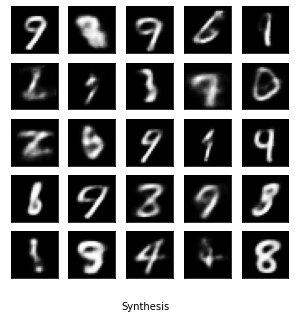

====> Epoch: 4 Average loss: 114.4976


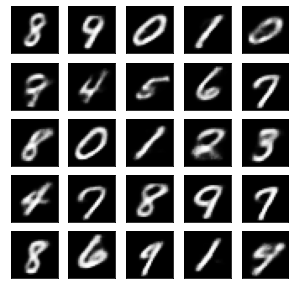

====> Test set loss: 112.0212
Train Epoch: 5 [0/60000 (0%)]	Loss: 112.814707
Train Epoch: 5 [10000/60000 (17%)]	Loss: 109.338535
Train Epoch: 5 [20000/60000 (33%)]	Loss: 109.360547
Train Epoch: 5 [30000/60000 (50%)]	Loss: 104.555420
Train Epoch: 5 [40000/60000 (67%)]	Loss: 112.287412
Train Epoch: 5 [50000/60000 (83%)]	Loss: 109.767295


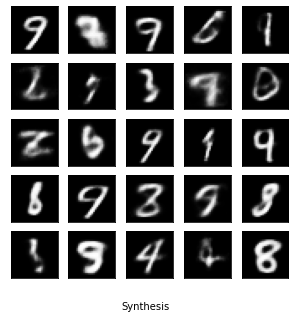

====> Epoch: 5 Average loss: 111.0485


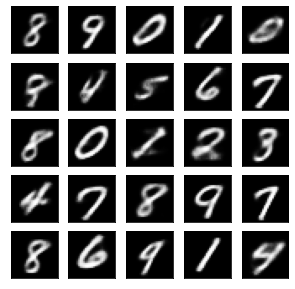

====> Test set loss: 109.2810
Train Epoch: 6 [0/60000 (0%)]	Loss: 107.954941
Train Epoch: 6 [10000/60000 (17%)]	Loss: 97.311797
Train Epoch: 6 [20000/60000 (33%)]	Loss: 112.615771
Train Epoch: 6 [30000/60000 (50%)]	Loss: 107.784189
Train Epoch: 6 [40000/60000 (67%)]	Loss: 112.375762
Train Epoch: 6 [50000/60000 (83%)]	Loss: 106.563096


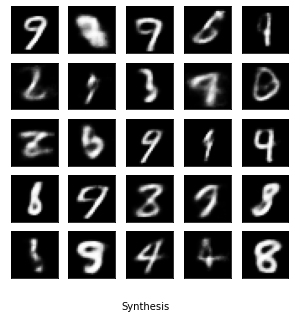

====> Epoch: 6 Average loss: 108.8504


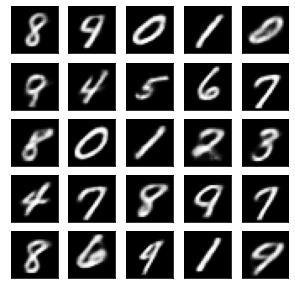

====> Test set loss: 107.5556
Train Epoch: 7 [0/60000 (0%)]	Loss: 103.183496
Train Epoch: 7 [10000/60000 (17%)]	Loss: 111.228037
Train Epoch: 7 [20000/60000 (33%)]	Loss: 110.641318
Train Epoch: 7 [30000/60000 (50%)]	Loss: 110.477529
Train Epoch: 7 [40000/60000 (67%)]	Loss: 106.318418
Train Epoch: 7 [50000/60000 (83%)]	Loss: 105.358662


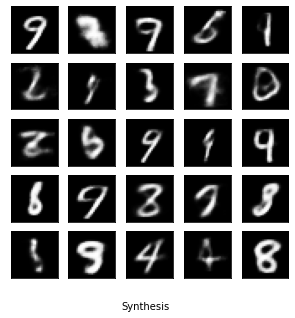

====> Epoch: 7 Average loss: 107.3785


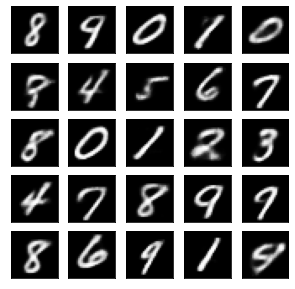

====> Test set loss: 106.7801
Train Epoch: 8 [0/60000 (0%)]	Loss: 105.141602
Train Epoch: 8 [10000/60000 (17%)]	Loss: 102.695508
Train Epoch: 8 [20000/60000 (33%)]	Loss: 110.305957
Train Epoch: 8 [30000/60000 (50%)]	Loss: 102.840713
Train Epoch: 8 [40000/60000 (67%)]	Loss: 106.069707
Train Epoch: 8 [50000/60000 (83%)]	Loss: 99.723203


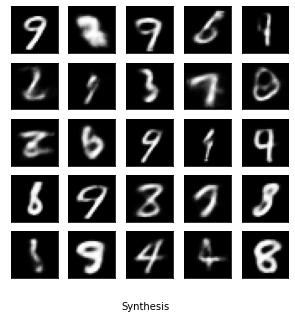

====> Epoch: 8 Average loss: 106.3559


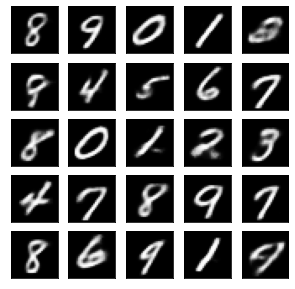

====> Test set loss: 105.6950
Train Epoch: 9 [0/60000 (0%)]	Loss: 105.440742
Train Epoch: 9 [10000/60000 (17%)]	Loss: 100.974619
Train Epoch: 9 [20000/60000 (33%)]	Loss: 101.133125
Train Epoch: 9 [30000/60000 (50%)]	Loss: 106.299072
Train Epoch: 9 [40000/60000 (67%)]	Loss: 102.709121
Train Epoch: 9 [50000/60000 (83%)]	Loss: 105.370430


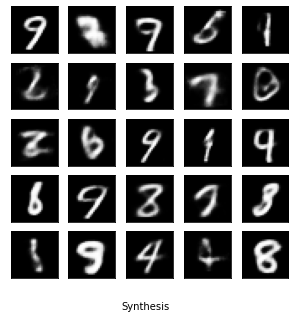

====> Epoch: 9 Average loss: 105.4962


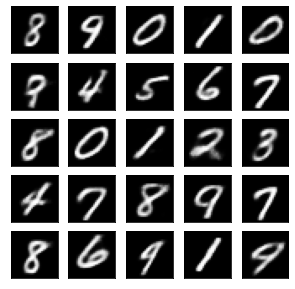

====> Test set loss: 105.1191
Train Epoch: 10 [0/60000 (0%)]	Loss: 105.008320
Train Epoch: 10 [10000/60000 (17%)]	Loss: 103.740488
Train Epoch: 10 [20000/60000 (33%)]	Loss: 104.088750
Train Epoch: 10 [30000/60000 (50%)]	Loss: 105.376875
Train Epoch: 10 [40000/60000 (67%)]	Loss: 100.548223
Train Epoch: 10 [50000/60000 (83%)]	Loss: 102.985879


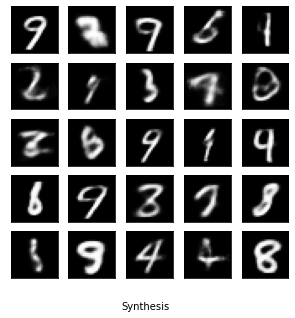

====> Epoch: 10 Average loss: 104.7745


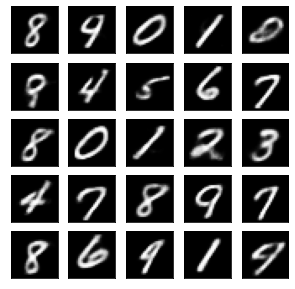

====> Test set loss: 104.6993


In [8]:

import matplotlib.pyplot as plt
trainloss=[]
testloss=[]
for epoch in range(1, 11):
    train(epoch)
    test()

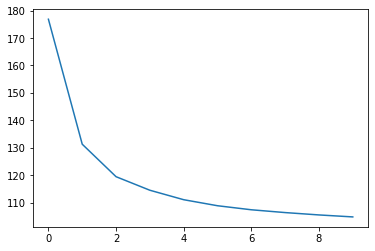

In [9]:
import matplotlib.pyplot as plt
plt.plot(trainloss)